In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import add, sub
import pandas as pd

np.random.seed(2017)

Let's generate random 2D data.

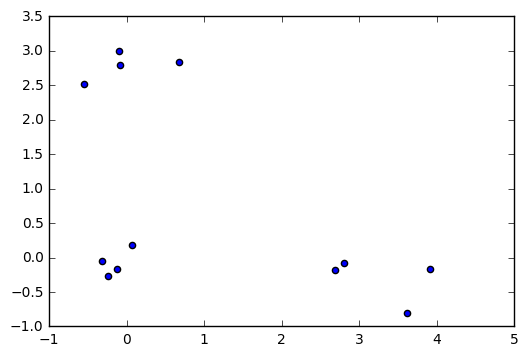

In [2]:
# Temporary cell. To be deleted later

N = 4
x_1 = np.random.multivariate_normal(mean = [0,0], cov = [[0.1,0],[0,0.1]], size = N)
x_2 = np.random.multivariate_normal(mean = [3,0], cov = [[0.3,-0.1],[-0.1,0.2]], size = N)
x_3 = np.random.multivariate_normal(mean = [0,3], cov = [[0.2,0],[0,0.2]], size = N)
N = 3 * N
X = np.concatenate((x_1, x_2, x_3))

plt.scatter(X[:,0], X[:,1])
plt.show()

pd.DataFrame(X).to_csv("gaussian_data.txt", sep="\t", header=None, index=True)

In [3]:
def a(i, k, R, N):
    if i != k:
        a = min([0, R[k, k] + sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != i and i_prime != k])])
    else:
        a = sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != k])
    return a

def r(i, k, A, S, N):
    r = S[i, k] - max([A[i, k_prime] + S[i, k_prime] for k_prime in range(N) if k_prime != k])
    return r

def s(x_i, x_k):
    s = -np.sum((x_i - x_k) ** 2)
    return s

def GenerateSimilarityMatrixNoSpark(data, N):
    S = np.zeros((N, N))
    # As the matrix is symetric, we don't compute the similarity for each couple
    for r in range(N): # For each row
        for c in range(r + 1, N): # For each column
            tmp = s(data[r], data[c])
            S[r, c] = tmp
            S[c, r] = tmp

    # For diagonal: compute "preferences"
    flatS = S.flatten()
    for i in range(N):
        S[i, i] = np.median(flatS[flatS != 0.0])
        
    return S

Let's compute the similarity matrix.

In [4]:
# As we can't rely on data order in a Map/Reduce paradigm, we add the values' coordinates in each row.
def addCoordinates(row):
    """
    This function adds the matrix coordinates to each value.

    Parameters
    ----------
    row: row of Spark RDD
            This is one row of the current Spark RDD we're parsing.

    Returns
    -------
    result: list
            This is the preprocessed row, with coordinates added.
    """
    
    values = row.split("\t")
    index = int(values[0])
    values = [float(_) for _ in values[1:]]
    result = [[index, j, v] for j, v in enumerate(values)]
    
    return result

def computeSimilarity(row):
    """
    This function adds the matrix coordinates to each value.

    Parameters
    ----------
    row: row of Spark RDD
            This is one row of the current Spark RDD we're parsing.

    Returns
    -------
    similarity: tuple
            This is computed similarity, with matrix coordinates added.
    """
    
    ((i, v1), (j, v2)) = row
    similarity = i, j, -1 * ((v1 - v2) ** 2)
    
    return similarity

def GenerateSimilarityMatrix():
    """
    This method generates the similarity matrix for all the points given to the mapper.

    Parameters
    ----------
    None

    Returns
    -------
    S: Spark RDD
            This is the computed similarity matrix in the Spark RDD format.
    """
    
    # Open the text file and add coordinates to each row
    mat1 = sc.textFile("gaussian_data.txt") 
    new_mat1 = mat1.flatMap(addCoordinates)
    
    # Generate a RDD for x coordinates and one for y coordinates
    new_mat_x = new_mat1.filter(lambda x: x[1] == 0).map(lambda row: (row[0], row[2]))
    new_mat_y = new_mat1.filter(lambda x: x[1] == 1).map(lambda row: (row[0], row[2]))
    
    # Compute the cartesian product for x and y
    mat_cartesian_x = new_mat_x.cartesian(new_mat_x)
    mat_cartesian_y = new_mat_y.cartesian(new_mat_y)
    
    # Compute the similarity for x and y
    sim_x = mat_cartesian_x.map(computeSimilarity)
    sim_y = mat_cartesian_y.map(computeSimilarity)
    
    # Concatenate both x- and y-RDD and sum them by identical keys. Remove cells that equal zero
    sim = sc.union([sim_x, sim_y])
    final = sim.map(lambda row: ((row[0], row[1]), row[2])).reduceByKey(add).filter(lambda x: x[1] != 0)
    
    # Compute the matrix's diagonal
    median = np.median(final.map(lambda row: row[1]).collect())
    diagonal = sc.parallelize(range(mat1.count())).map(lambda x: ((x, x), median))
    
    # Generate the final matrix
    S = sc.union([final, diagonal])
    
    return S

S = GenerateSimilarityMatrix()
S = sc.parallelize(S.collect())

In [5]:
S_exec = GenerateSimilarityMatrix().collect()
S_exec

[((5, 9), -28.306493800227994),
 ((7, 3), -9.269238470501065),
 ((10, 8), -0.58622799988781),
 ((4, 10), -13.158299014496219),
 ((0, 6), -17.93785575719257),
 ((2, 8), -8.812833092648498),
 ((8, 6), -24.787897562460067),
 ((7, 11), -17.803092429255358),
 ((10, 0), -9.330237623701416),
 ((4, 2), -7.901701568514601),
 ((11, 7), -17.803092429255358),
 ((2, 0), -0.05452688889137475),
 ((3, 7), -9.269238470501065),
 ((5, 1), -13.559717604119594),
 ((9, 5), -28.306493800227994),
 ((6, 4), -1.4981817332452352),
 ((1, 5), -13.559717604119594),
 ((1, 2), -0.15662275313700152),
 ((3, 8), -9.442732590050783),
 ((7, 4), -0.02444745673672733),
 ((8, 1), -6.887713118937767),
 ((9, 10), -1.615324039278445),
 ((5, 6), -0.49015245849440575),
 ((1, 10), -7.455220236745148),
 ((6, 11), -26.00720936883958),
 ((2, 7), -8.581598929236517),
 ((3, 0), -0.05782447599593958),
 ((6, 3), -17.19416369001456),
 ((4, 5), -1.2439938388864276),
 ((11, 8), -0.037494100105317105),
 ((10, 7), -13.02644619729104),
 ((0, 9

In [6]:
S_nospark = GenerateSimilarityMatrixNoSpark(X, N)
pd.DataFrame(S_nospark)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-9.172506,-0.200299,-0.054527,-0.057824,-9.075774,-16.061495,-17.937856,-9.776694,-8.153382,-6.591721,-9.330238,-9.290721
1,-0.200299,-9.172506,-0.156623,-0.290824,-7.009766,-13.559718,-14.920066,-7.573441,-6.887713,-5.814151,-7.455220,-7.940903
2,-0.054527,-0.156623,-9.172506,-0.022383,-7.901702,-14.366898,-16.280537,-8.581599,-8.812833,-7.364384,-9.695851,-9.999332
3,-0.057824,-0.290824,-0.022383,-9.172506,-8.542562,-15.086845,-17.194164,-9.269238,-9.442733,-7.833802,-10.502759,-10.667409
4,-9.075774,-7.009766,-7.901702,-8.542562,-9.172506,-1.243994,-1.498182,-0.024447,-16.572838,-17.721489,-13.158299,-17.786834
5,-16.061495,-13.559718,-14.366898,-15.086845,-1.243994,-9.172506,-0.490152,-1.180593,-26.658248,-28.306494,-21.877597,-28.120449
6,-17.937856,-14.920066,-16.280537,-17.194164,-1.498182,-0.490152,-9.172506,-1.233670,-24.787898,-27.077280,-19.500747,-26.007209
7,-9.776694,-7.573441,-8.581599,-9.269238,-0.024447,-1.180593,-1.233670,-9.172506,-16.628291,-17.945122,-13.026446,-17.803092
8,-8.153382,-6.887713,-8.812833,-9.442733,-16.572838,-26.658248,-24.787898,-16.628291,-9.172506,-0.297600,-0.586228,-0.037494
9,-6.591721,-5.814151,-7.364384,-7.833802,-17.721489,-28.306494,-27.077280,-17.945122,-0.297600,-9.172506,-1.615324,-0.442913


Let's compute the matrix R.

In [7]:
def computeR(A, R, S, N):
    # Compute the sum of A and S
    sumA_S = sc.union([A, S]).reduceByKey(add)

    # Remove all rows where i == k and compute the maximum
    tmp = sc.parallelize(range(N)).cartesian(sumA_S)
    tmp = tmp.map(lambda row: (row[0], (row[1][0][1], (row[1][0][0], row[1][1])))).filter(lambda row: row[1][0] != row[0])
    maximum = tmp.map(lambda row: ((row[1][1][0], row[0]), row[1][1][1])).reduceByKey(max)

    # Compute r
    r = sc.union([S, maximum]).reduceByKey(sub)

    # Compute R
    R = R.join(r).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return R

In [8]:
A = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
R = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
lambdaValue = 0.5

R = computeR(A, R, S, N)
R_exec = R.collect()
R_exec

[((11, 7), -8.88279916457502),
 ((10, 8), 0.01406566166611295),
 ((3, 8), -4.710174976823565),
 ((7, 4), 0.5780728201352309),
 ((6, 3), -8.352005615760076),
 ((11, 8), 0.20270950282187514),
 ((10, 7), -6.220109098701615),
 ((8, 1), -3.4251095094162247),
 ((9, 2), -3.533392166577991),
 ((9, 3), -3.768101231564982),
 ((7, 5), -0.5780728201352309),
 ((11, 9), -0.20270950282187514),
 ((6, 2), -7.895192285847911),
 ((3, 9), -3.905709917531394),
 ((8, 0), -4.057943788806791),
 ((10, 6), -9.457259604202623),
 ((2, 5), -7.172257888350786),
 ((1, 0), -0.021838215574774014),
 ((0, 3), -0.0016487935522824168),
 ((10, 4), -6.286035507304204),
 ((9, 1), -2.758275551676441),
 ((8, 2), -4.387669496271591),
 ((11, 11), -4.5675061064347977),
 ((7, 7), -4.5740294281190925),
 ((6, 0), -8.723851649349081),
 ((3, 11), -5.322512992697233),
 ((2, 3), 0.01607212624386011),
 ((0, 5), -8.003483861962096),
 ((1, 6), -7.381721399656205),
 ((1, 7), -3.7084089252123413),
 ((0, 4), -4.510623633278692),
 ((2, 2), -4.

In [9]:
A_nospark = np.zeros((N, N))
R_nospark = np.zeros((N, N))
lambdaValue = 0.5

# Update r(i, k) given a(i, k)
for i in range(N): # For each row
    for k in range(N): # For each column
        R_nospark[i, k] = (1 - lambdaValue) * r(i, k, A_nospark, S_nospark, N) + lambdaValue * R_nospark[i, k]
        
pd.DataFrame(R_nospark)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-4.558990,-0.072886,0.001649,-0.001649,-4.510624,-8.003484,-8.941664,-4.861084,-4.049427,-3.268597,-4.637855,-4.618097
1,-0.021838,-4.507942,0.021838,-0.067100,-3.426572,-6.701547,-7.381721,-3.708409,-3.365545,-2.828764,-3.649299,-3.892140
2,-0.016072,-0.067120,-4.575062,0.016072,-3.939659,-7.172258,-8.129077,-4.279608,-4.395225,-3.671001,-4.836734,-4.988475
3,-0.017721,-0.134220,0.017721,-4.575062,-4.260090,-7.532231,-8.585891,-4.623428,-4.710175,-3.905710,-5.240188,-5.322513
4,-4.525663,-3.492659,-3.938627,-4.259057,-4.574029,-0.609773,-0.736867,0.609773,-8.274195,-8.848521,-6.566926,-8.881193
5,-7.785671,-6.534783,-6.938373,-7.298346,-0.376921,-4.341177,0.345220,-0.345220,-13.084048,-13.908171,-10.693722,-13.815148
6,-8.723852,-7.214957,-7.895192,-8.352006,-0.504015,0.371759,-4.341177,-0.371759,-12.148873,-13.293564,-9.505297,-12.758528
7,-4.876123,-3.774497,-4.278576,-4.622396,0.578073,-0.578073,-0.604611,-4.574029,-8.301922,-8.960337,-6.500999,-8.889322
8,-4.057944,-3.425110,-4.387669,-4.702619,-8.267672,-13.310377,-12.375202,-8.295399,-4.567506,-0.130053,-0.274367,0.130053
9,-3.147060,-2.758276,-3.533392,-3.768101,-8.711944,-14.004447,-13.389840,-8.823761,0.072657,-4.437453,-0.658862,-0.072657


Let's compute the matrix A.

In [10]:
def computeA(A, R, N):
    """
    if i != k:
        a = min([0, R[k, k] + sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != i and i_prime != k])])
    else:
        a = sum([max(0, R[i_prime, k]) for i_prime in range(N) if i_prime != k])
    """
    
    # Remove all rows where i == k and compute the maximum
    tmp = R.filter(lambda row: row[0][0] != row[0][1])
    tmp = sc.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][0] and row[0] != row[1][0][1])
    tmp = tmp.map(lambda row: ((row[0], row[1][0][1]), row[1][0][0])).join(R)
    maximum = tmp.map(lambda row: ((row[1][0], row[0][1]), max(0, row[1][1]))).reduceByKey(add)
    
    # Add R[k, k]
    tmp = maximum.map(lambda row: ((row[0][1], row[0][1]), row)).join(R.filter(lambda row: row[0][0] == row[0][1]))
    a = tmp.map(lambda row: (row[1][0][0], min(0, row[1][0][1] + row[1][1])))
    
    # Compute the value of a when i == k
    tmp = R.filter(lambda row: row[0][0] == row[0][1])
    tmp = sc.parallelize(range(N)).cartesian(tmp).filter(lambda row: row[0] != row[1][0][1])
    tmp = tmp.map(lambda row: ((row[0], row[1][0][1]), row[1][0][0])).join(R)
    maximum2 = tmp.map(lambda row: ((row[1][0], row[0][1]), max(0, row[1][1]))).reduceByKey(add)

    # Join both RDDs
    a = sc.union([a, maximum2])

    # Compute A
    A = A.join(a).map(lambda row: (row[0], (1 - lambdaValue) * row[1][1] + lambdaValue * row[1][0]))
    
    return A

In [11]:
R = sc.parallelize(R_exec)
A = computeA(A, R, N)
A_exec = A.collect()
A_exec

[((3, 7), -1.9821281185221213),
 ((9, 5), -1.9847091681017981),
 ((1, 10), -2.1465695782717753),
 ((3, 0), -2.2794948560208845),
 ((6, 11), -2.2187265761596087),
 ((9, 2), -2.2669269546812152),
 ((4, 4), 0.28903641006761543),
 ((10, 6), -1.9979783039919308),
 ((6, 1), -2.2539708899594775),
 ((1, 0), -2.2794948560208845),
 ((9, 8), -2.1753654709734049),
 ((3, 10), -2.1465695782717753),
 ((11, 11), 0.06502647705779029),
 ((0, 10), -2.1465695782717753),
 ((8, 2), -2.2669269546812152),
 ((5, 5), 0.1858792955183286),
 ((4, 9), -2.2187265761596082),
 ((7, 0), -2.2794948560208845),
 ((2, 3), -2.2875309191428146),
 ((10, 11), -2.2187265761596087),
 ((11, 5), -1.9847091681017981),
 ((5, 11), -2.2187265761596087),
 ((0, 4), -1.9979783039919308),
 ((8, 7), -1.9821281185221213),
 ((5, 0), -2.2794948560208845),
 ((1, 5), -1.9847091681017981),
 ((6, 4), -1.9979783039919308),
 ((1, 2), -2.2778460624686021),
 ((3, 8), -2.1390371966202575),
 ((6, 3), -2.2794948560208845),
 ((9, 10), -2.1465695782717753

In [12]:
# Update a(i, k) given r(i, k)
for i in range(N): # For each row
    for k in range(N): # For each column
        A_nospark[i, k] = (1 - lambdaValue) * a(i, k, R_nospark, N) + lambdaValue * A_nospark[i, k]
        
pd.DataFrame(A_nospark)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,-2.253971,-2.267751,-2.279495,-1.997978,-1.984709,-1.997978,-1.982128,-2.139037,-2.218727,-2.14657,-2.218727
1,-2.279495,0.000000,-2.277846,-2.279495,-1.997978,-1.984709,-1.997978,-1.982128,-2.139037,-2.218727,-2.14657,-2.218727
2,-2.279495,-2.253971,0.020604,-2.287531,-1.997978,-1.984709,-1.997978,-1.982128,-2.139037,-2.218727,-2.14657,-2.218727
3,-2.279495,-2.253971,-2.275787,0.008036,-1.997978,-1.984709,-1.997978,-1.982128,-2.139037,-2.218727,-2.14657,-2.218727
4,-2.279495,-2.253971,-2.266927,-2.279495,0.289036,-1.984709,-1.997978,-2.287015,-2.139037,-2.218727,-2.14657,-2.218727
5,-2.279495,-2.253971,-2.266927,-2.279495,-1.997978,0.185879,-2.170588,-1.982128,-2.139037,-2.218727,-2.14657,-2.218727
6,-2.279495,-2.253971,-2.266927,-2.279495,-1.997978,-2.170588,0.172610,-1.982128,-2.139037,-2.218727,-2.14657,-2.218727
7,-2.279495,-2.253971,-2.266927,-2.279495,-2.287015,-1.984709,-1.997978,0.304887,-2.139037,-2.218727,-2.14657,-2.218727
8,-2.279495,-2.253971,-2.266927,-2.279495,-1.997978,-1.984709,-1.997978,-1.982128,0.144716,-2.218727,-2.14657,-2.283753
9,-2.279495,-2.253971,-2.266927,-2.279495,-1.997978,-1.984709,-1.997978,-1.982128,-2.175365,0.000000,-2.14657,-2.218727


In [13]:
S_nospark = GenerateSimilarityMatrixNoSpark(X, N)

A_nospark = np.zeros((N, N))
R_nospark = np.zeros((N, N))
lambdaValue = 0.5

for i in range(100):
    # Update r(i, k) given a(i, k)
    for i in range(N): # For each row
        for k in range(N): # For each column
            R_nospark[i, k] = (1 - lambdaValue) * r(i, k, A_nospark, S_nospark, N) + lambdaValue * R_nospark[i, k]
            
    # Update a(i, k) given r(i, k)
    for i in range(N): # For each row
        for k in range(N): # For each column
            A_nospark[i, k] = (1 - lambdaValue) * a(i, k, R_nospark, N) + lambdaValue * A_nospark[i, k]

    # Combine both a(i, k) and r(i, k) to get centers
    centers = [i for i in range(N) if R_nospark[i, i] + A_nospark[i, i] > 0]
    
centers

[2, 7, 8]

Let's run the algorithm.

In [14]:
import time

# Create A and R matrices
A = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
R = sc.parallelize(range(N)).flatMap(lambda x: [((x, y), 0) for y in range(N)])
lambdaValue = 0.5

# Start the timer
startTime = time.time()

iterations = 100
for iter in range(iterations):
    if iter % 2 == 0:
        print(iter, "iterations done")
    # Update r(i, k) given a(i, k)
    R = computeR(A, R, S, N)
    
    # Actually execute the code
    R_exec = R.collect()
    R = sc.parallelize(R_exec)
    
    # Update a(i, k) given r(i, k)
    A = computeA(A, R, N)
    
    # Actually execute the code
    A_exec = A.collect()
    A = sc.parallelize(A_exec)    
    
# Stop the timer and print the exectution time
print("Exec: --- %s seconds ---" % (time.time() - startTime))

0 iterations done
2 iterations done
4 iterations done
6 iterations done
8 iterations done
10 iterations done
12 iterations done
14 iterations done
16 iterations done
18 iterations done
20 iterations done
22 iterations done
24 iterations done
26 iterations done
28 iterations done
30 iterations done
32 iterations done
34 iterations done
36 iterations done
38 iterations done
40 iterations done
42 iterations done
44 iterations done
46 iterations done
48 iterations done
50 iterations done
52 iterations done
54 iterations done
56 iterations done
58 iterations done
60 iterations done
62 iterations done
64 iterations done
66 iterations done
68 iterations done
70 iterations done
72 iterations done
74 iterations done
76 iterations done
78 iterations done
80 iterations done
82 iterations done
84 iterations done
86 iterations done
88 iterations done
90 iterations done
92 iterations done
94 iterations done
96 iterations done
98 iterations done
Exec: --- 844.5870606899261 seconds ---


Let's compute the centers.

In [15]:
A_matrix = np.zeros((N, N))
R_matrix = np.zeros((N, N))

A_list = A.collect()
A_list.sort()

R_list = R.collect()
R_list.sort()

for item in A_list:
    A_matrix[item[0][0], item[0][1]] = item[1]
    
for item in R_list:
    R_matrix[item[0][0], item[0][1]] = item[1]

# Combine both a(i, k) and r(i, k) to get centers
centers = [i for i in range(N) if R_matrix[i, i] + A_matrix[i, i] > 0]
centers

[2, 7, 8]